In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn
import pandas as pd
from scipy.stats import gaussian_kde
%matplotlib inline

In [2]:
def estimateparamsbayes(X,questions,allbest,allworst,w0=[],weights=[],tol=.0001,maxiter=100):
    tol=.001
    val=1
    [numofq,nitems]=X.shape
    if len(w0)<nitems or (np.abs(w0)>4).any():
        w=np.zeros(nitems)    
    else:
        w=w0.copy()
    if len(weights)<numofq:
        weights=np.ones(numofq)
    iternum=0
    nb=np.bincount(allbest,weights,minlength=nitems)
    nw=np.bincount(allworst,weights,minlength=nitems)
    inplay=np.where(np.bincount(questions.flatten(),minlength=nitems)>0)[0]
    notinplay=np.where(np.bincount(questions.flatten(),minlength=nitems)==0)[0]
    try:
        while val>tol and iternum<maxiter:
            zb=np.sum(np.exp(w[questions]),1)
            zw=np.sum(np.exp(-w[questions]),1)
            Pb=((1/(zb)*X.T).T*np.exp(w))#broadcasting
            Pw=((1/(zw)*X.T).T*np.exp(-w))#broadcasting
            wPb=(Pb.T*weights).T
            wPw=(Pw.T*weights).T
            gradb=nb-np.sum(wPb,0)
            gradw=-nw+np.sum(wPw,0)
            grad=-(gradb+gradw)
            Hb=np.dot(wPb.T,Pb)
            Hbd=-np.sum(wPb*(1-Pb),0)
            Hb+=-np.diag(np.diag(Hb))+np.diag(Hbd)
            Hw=np.dot(wPw.T,Pw)
            Hwd=-np.sum(wPw*(1-Pw),0)
            Hw+=-np.diag(np.diag(Hw))+np.diag(Hwd)
            H=-(Hb+Hw)
            #gradl=grad[:-1]
            #Hl=H[:-1,:-1]
            gradl=grad[inplay[:-1]]
            Hl=H[inplay[:-1],:][:,inplay[:-1]]
            #Hlinv=np.linalg.pinv(Hl)
            #Hinvgradl=np.dot(Hlinv,gradl)
            Hinvgradl=np.linalg.solve(Hl,gradl)
            #w[:-1]=w[:-1]-Hinvgradl
            w[inplay[:-1]]=w[inplay[:-1]]-Hinvgradl
            val=np.dot(gradl,Hinvgradl)
            iternum+=1
    except np.linalg.linalg.LinAlgError:
        print('error')
        print(numofq*4/12)
        return np.random.randn(nitems)/4
    if np.isnan(w).any():
        print('nan')
        print(numofq*4/12)
        return np.random.randn(nitems)/4
        #raise Exception('w contains nan')
    w[notinplay]=w[np.random.choice(inplay,notinplay.shape[0])]+.001
    return w

In [3]:
def getdraws(data,N=100,resp=60):
    iternum=50
    itemnum=120
    choicecol=['Choice1','Choice2', 'Choice3', 'Choice4', 'Choice5']
    choices=data[np.logical_and(data['Iter']==iternum,data['RespIDNum']<=resp)][choicecol].get_values()-1
    best=data[np.logical_and(data['Iter']==iternum,data['RespIDNum']<=resp)]['Best'].get_values()-1
    worst=data[np.logical_and(data['Iter']==iternum,data['RespIDNum']<=resp)]['Worst'].get_values()-1
    [numofq,items]=choices.shape
    X=np.zeros((numofq,itemnum))
    for z,row in enumerate(choices):
        X[z,row]=1
    draws=np.zeros((N,itemnum))
    for j in range(N):
        weights=np.random.exponential(1,numofq)
        draws[j]=estimateparamsbayes(X,choices,best,worst,weights=weights)
    return draws

In [4]:
def getdifdraws(data,N=100,resp=60,delta=.25):
    iternum=50
    itemnum=120
    choicecol=['Choice1','Choice2', 'Choice3', 'Choice4', 'Choice5']
    choices=data[np.logical_and(data['Iter']==iternum,data['RespIDNum']<=resp)][choicecol].get_values()-1
    best=data[np.logical_and(data['Iter']==iternum,data['RespIDNum']<=resp)]['Best'].get_values()-1
    worst=data[np.logical_and(data['Iter']==iternum,data['RespIDNum']<=resp)]['Worst'].get_values()-1
    [numofq,items]=choices.shape
    X=np.zeros((numofq,itemnum))
    for z,row in enumerate(choices):
        X[z,row]=1
    draws=np.zeros((N,itemnum))
    
    subsamp=int(numofq*delta)
    for j in range(N):
        #weights=np.random.exponential(1,numofq)
        #sub=np.random.choice([x for x in range(0,numofq)],subsamp,p=weights/np.sum(weights))
        sub=np.random.choice([x for x in range(0,numofq)],subsamp)
        tempX=X[sub]
        tempb=best[sub]
        tempw=worst[sub]
        tempq=choices[sub]
        weights=np.random.exponential(1,subsamp)
        draws[j]=estimateparamsbayes(tempX,tempq,tempb,tempw,weights=weights)
    return draws

In [5]:

data1=pd.read_csv('HB_120items.csv')
utilsall=data1.get_values()[:,2:]
realmean=np.mean(utilsall,0)

In [183]:
np.random.choice?

In [16]:
files=['fixed_express-120v20','TS-120v20']
item1=72
item2=89
dens=[]
resp=60
for filename in files:
    data=pd.read_csv('Results/choice_data-'+filename+'.csv')
    draws=getdraws(data,N=1000,resp=resp)
    dens+=[gaussian_kde(draws[:,item1])]
    dens+=[gaussian_kde(draws[:,item2])]

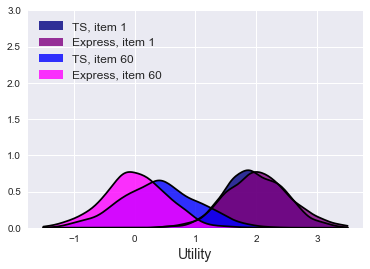

In [17]:
x = np.linspace(-1.5,3.5,200)
plt.fill_between(x, 0, dens[2](x),facecolor='Navy', alpha=0.8,label='TS, item 1')
plt.fill_between(x, 0, dens[0](x),facecolor='Purple', alpha=0.8,label='Express, item 1')
plt.fill_between(x, 0, dens[3](x),facecolor='Blue', alpha=0.8,label='TS, item 60')
plt.fill_between(x, 0, dens[1](x),facecolor='Fuchsia', alpha=0.8,label='Express, item 60')
plt.plot(x,dens[2](x),'k')
plt.plot(x,dens[0](x),'k')
plt.plot(x,dens[3](x),'k')
plt.plot(x,dens[1](x),'k')
plt.legend(loc='upper left',fontsize=12)
plt.xlabel('Utility',fontsize=14)
plt.ylim(0,3)
name='utildis'+str(resp)+'.pdf'
plt.savefig('plots/'+name, dpi=100)

In [20]:
filename='TSe4-120v20'
item1=72
item2=89
dens=[]
resp=300

data=pd.read_csv('Results/choice_data-'+filename+'.csv')
draws=getdraws(data,N=100,resp=resp)
dens+=[gaussian_kde(draws[:,item1])]
dens+=[gaussian_kde(draws[:,item2])]
draws=getdifdraws(data,N=100,resp=resp)
dens+=[gaussian_kde(draws[:,item1])]
dens+=[gaussian_kde(draws[:,item2])]

In [21]:
for i in [0,1]:
    x = np.linspace(-1.5,3.5,200)
    plt.fill_between(x, 0, dens[0+i](x),facecolor='Red', alpha=0.8,label='TS')
    plt.fill_between(x, 0, .75*dens[0+i](x)+.25*dens[2+i](x),facecolor='Purple', alpha=0.8,label='combined')
    plt.fill_between(x, 0, dens[2+i](x),facecolor='Blue', alpha=0.8,label='diffuse')
    plt.plot(x,dens[0+i](x),'k')
    plt.plot(x,.75*dens[0+i](x)+.25*dens[2+i](x),'k')
    plt.plot(x,dens[2+i](x),'k')
    plt.legend(loc='upper left',fontsize=12)
    plt.xlabel('Utility',fontsize=14)
    plt.ylim(0,3)
    name='utildifdis'+str(resp)+str(i*60)+'.pdf'
    plt.savefig('plots/'+name, dpi=100)
    plt.close()

(array([  1.,   0.,   1.,   0.,   4.,   4.,   8.,  11.,  12.,   7.,   7.,
          8.,   9.,  10.,   7.,   3.,   2.,   2.,   1.,   3.]),
 array([-1.0089026 , -0.71548275, -0.42206289, -0.12864304,  0.16477681,
         0.45819666,  0.75161652,  1.04503637,  1.33845622,  1.63187607,
         1.92529593,  2.21871578,  2.51213563,  2.80555548,  3.09897534,
         3.39239519,  3.68581504,  3.97923489,  4.27265475,  4.5660746 ,
         4.85949445]),
 <a list of 20 Patch objects>)

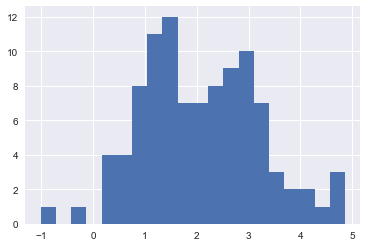

In [191]:
plt.hist(draws[:,item1],20)

In [177]:
np.argsort(draws[8])

array([ 51,  22,  65, 118,  61, 117,  13, 107,  80,  73,   7,  16,  57,
        24,  15,  75,  41,  78, 102,  60,  42,  36,  35,   5, 113,  79,
        59,  90,  86, 108,  81,  26,  12,  43,  50, 112,   6,  70,  88,
        82,  89,   8,  30,  47,  92,  19,  76,  23,  46,  32,  94,  52,
        71,  66,  37, 111,  54,  10, 119, 116,  27, 105,  58,  48,  14,
         4,  25,  69,  63,  21,  77,   9,  74, 109,  98, 104,  93,  96,
        31,  11,   3,  72,  67,  20, 110,  49, 115,  17,  83,  64, 100,
        33,   2,  68, 106,  95, 103,  44,  62,  45,   1,  91,  38,  34,
        40, 114,  97,   0,  29,  56,  28,  55, 101,  85,  99,  84,  39,
        87,  18,  53])